In [1]:
#in this notebook we'll convert numerical continous data to numerical discrete data
#importing essentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer

In [6]:
df=pd.read_csv('train.csv', usecols=['Age', 'Fare','Survived'])

In [7]:
df.isnull().sum()

Survived      0
Age         177
Fare          0
dtype: int64

In [8]:
df.dropna(inplace=True)

In [9]:
df.isnull().sum()

Survived    0
Age         0
Fare        0
dtype: int64

In [11]:
df.shape #three columns

(714, 3)

In [13]:
print(df.head)

<bound method NDFrame.head of      Survived   Age     Fare
0           0  22.0   7.2500
1           1  38.0  71.2833
2           1  26.0   7.9250
3           1  35.0  53.1000
4           0  35.0   8.0500
..        ...   ...      ...
885         0  39.0  29.1250
886         0  27.0  13.0000
887         1  19.0  30.0000
889         1  26.0  30.0000
890         0  32.0   7.7500

[714 rows x 3 columns]>


In [14]:
X=df.iloc[:,1:]
y=df.iloc[:,-3]

In [15]:
#train test split 
X_train, X_test, y_train,y_test= train_test_split(X,
                                                  y,
                                                  test_size=0.3,
                                                  random_state=42)


In [18]:
X_train.head(10)

,Age,Fare
37,21.0,8.0500
58,5.0,27.7500
57,28.5,7.2292
94,59.0,7.2500
209,40.0,31.0000
621,42.0,52.5542
784,25.0,7.0500
86,16.0,34.3750
12,20.0,8.0500
397,46.0,26.0000


In [19]:
X_test.head(10)

,Age,Fare
149,42.0,13.0000
407,3.0,18.7500
53,29.0,26.0000
369,24.0,69.3000
818,43.0,6.4500
549,8.0,36.7500
85,33.0,15.8500
774,54.0,23.0000
100,28.0,7.8958
816,23.0,7.9250


In [20]:
#decisiontreeclassifier to calculate accuracy before any conversion
clf=DecisionTreeClassifier()
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.6139534883720931

## acc score without any cnv .61

In [21]:
#cross val
np.mean(cross_val_score(DecisionTreeClassifier(),X,y,cv=10,scoring='accuracy'))

0.6261150234741784

## cross val without cnv .62

In [23]:
#quantile binning
kbin_age=KBinsDiscretizer(n_bins=15,encode='ordinal',strategy='quantile')
kbin_fare=KBinsDiscretizer(n_bins=15,encode='ordinal',strategy='quantile')

In [24]:
#transformer
trf =ColumnTransformer([
    ('first',kbin_age,[0]), #call by indexing
    ('second',kbin_fare,[1])
])

In [25]:
#fit and transform
X_train_trf=trf.fit_transform(X_train)
X_test_trf=trf.transform(X_test)

In [26]:
trf.named_transformers_

{'first': KBinsDiscretizer(encode='ordinal', n_bins=15),
 'second': KBinsDiscretizer(encode='ordinal', n_bins=15)}

In [27]:
trf.named_transformers_['first']

KBinsDiscretizer(encode='ordinal', n_bins=15)

In [29]:
trf.named_transformers_['first'].n_bins

15

In [30]:
trf.named_transformers_['first'].bin_edges_

array([array([ 0.67,  6.2 , 16.  , 19.  , 21.  , 24.  , 25.  , 28.  , 30.  ,
              32.  , 35.  , 39.  , 42.  , 47.6 , 54.  , 80.  ])             ],
      dtype=object)

In [31]:
trf.named_transformers_['second'].bin_edges_

array([array([  0.     ,   7.25   ,   7.78332,   7.8958 ,   8.05   ,  10.5    ,
               13.     ,  14.4542 ,  19.5    ,  26.     ,  26.55   ,  31.57416,
               52.     ,  76.7292 , 110.8833 , 263.     ])                     ],
      dtype=object)

In [33]:
#changes 
output =pd.DataFrame({
    'age':X_train['Age'],
    'age_trf':X_train_trf[:,0],
    'fare':X_train['Fare'],
    'fare_trf':X_train_trf[:,1]
})

#takes the same bin edges learned by the discretizer (KBinsDiscretizer) and applies them via pd.cut to label each person’s Age and Fare with the correct bin.
output['age_labels'] = pd.cut(x=X_train['Age'],
                                    bins=trf.named_transformers_['first'].bin_edges_[0].tolist())
output['fare_labels'] = pd.cut(x=X_train['Fare'],
                                    bins=trf.named_transformers_['second'].bin_edges_[0].tolist())

In [34]:
output.sample(10)

,age,age_trf,fare,fare_trf,age_labels,fare_labels
67,19.0,3.0,8.1583,4.0,"(16.0, 19.0]","(8.05, 10.5]"
586,47.0,12.0,15.0000,7.0,"(42.0, 47.6]","(14.454, 19.5]"
16,2.0,0.0,29.1250,10.0,"(0.67, 6.2]","(26.55, 31.574]"
297,2.0,0.0,151.5500,14.0,"(0.67, 6.2]","(110.883, 263.0]"
325,36.0,10.0,135.6333,14.0,"(35.0, 39.0]","(110.883, 263.0]"
488,30.0,8.0,8.0500,4.0,"(28.0, 30.0]","(7.896, 8.05]"
33,66.0,14.0,10.5000,5.0,"(54.0, 80.0]","(8.05, 10.5]"
850,4.0,0.0,31.2750,10.0,"(0.67, 6.2]","(26.55, 31.574]"
145,19.0,3.0,36.7500,11.0,"(16.0, 19.0]","(31.574, 52.0]"
437,24.0,5.0,18.7500,7.0,"(21.0, 24.0]","(14.454, 19.5]"


In [35]:
#classifier after changes
clf=DecisionTreeClassifier()
clf.fit(X_train_trf,y_train)
y_pred2=clf.predict(X_test_trf)

In [36]:
accuracy_score(y_test,y_pred2)

0.6372093023255814

## acc score after quantile binning is .63 improved by 2%

In [37]:
#find and compare for cross validatiion
X_trf=trf.fit_transform(X)
np.mean(cross_val_score(DecisionTreeClassifier(),X,y,cv=10,scoring='accuracy'))

0.6303208137715179

## acc score after quantile binning is .63 improved by 1%

In [41]:
#code for all three types of binning
def discretize(bins,strategy):
    kbin_age=KBinsDiscretizer(n_bins=bins,encode='ordinal',strategy=strategy)
    kbin_fare=KBinsDiscretizer(n_bins=bins,encode='ordinal',strategy=strategy)

    trf=ColumnTransformer([
    ('first',kbin_age,[0]),
    ('second',kbin_fare,[1])
    ])

#find cross val
    X_trf = trf.fit_transform(X)
    print(np.mean(cross_val_score(DecisionTreeClassifier(),X,y,cv=10,scoring='accuracy')))


#plot graphs
    plt.figure(figsize=(14,4))
    plt.subplot(121)
    plt.hist(X['Age'])
    plt.title("Before")

    plt.subplot(122)
    plt.hist(X_trf[:,0],color='red')
    plt.title("After")

    plt.show()
    
    plt.figure(figsize=(14,4))
    plt.subplot(121)
    plt.hist(X['Fare'])
    plt.title("Before")

    plt.subplot(122)
    plt.hist(X_trf[:,1],color='red')
    plt.title("Fare")

    plt.show()
    

0.6219092331768388


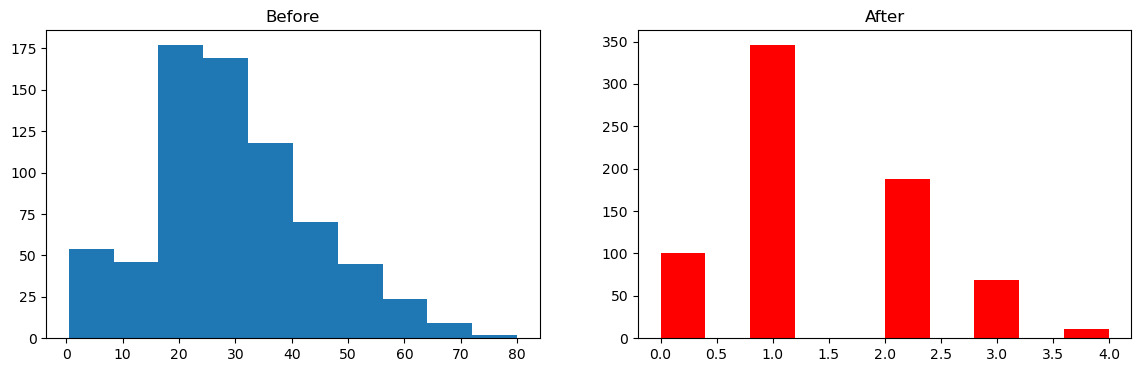

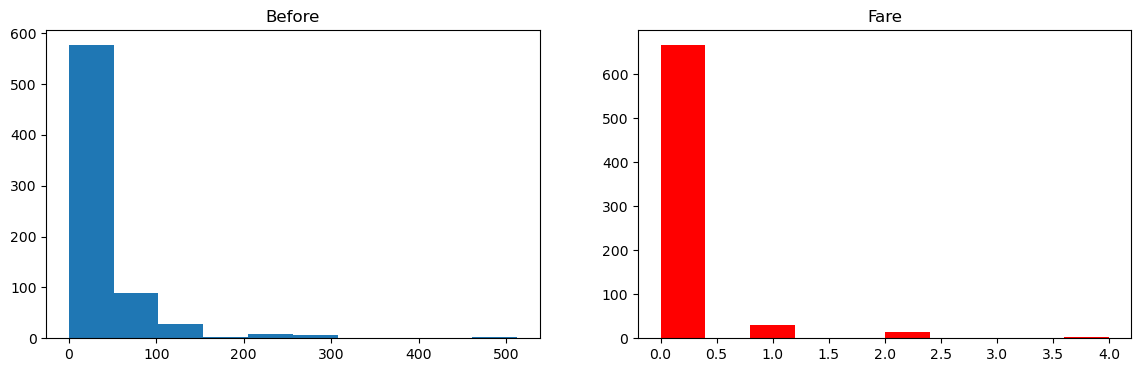

In [42]:
discretize(5,'uniform')

0.6288928012519561


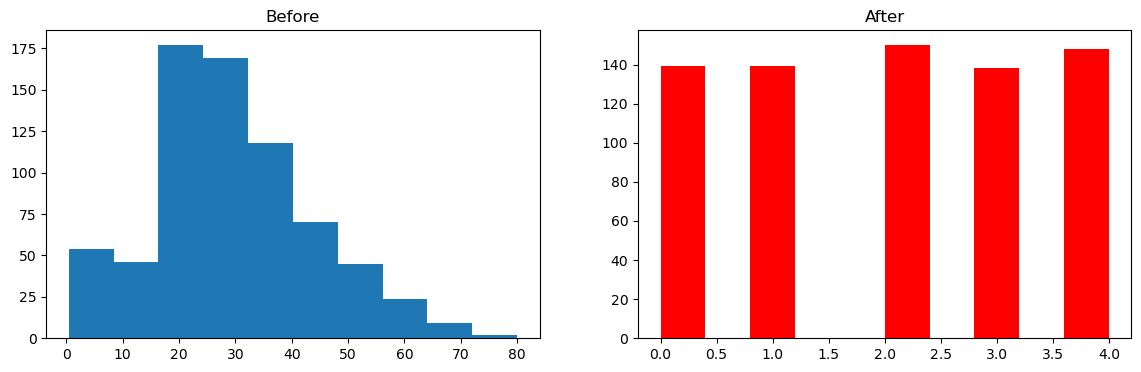

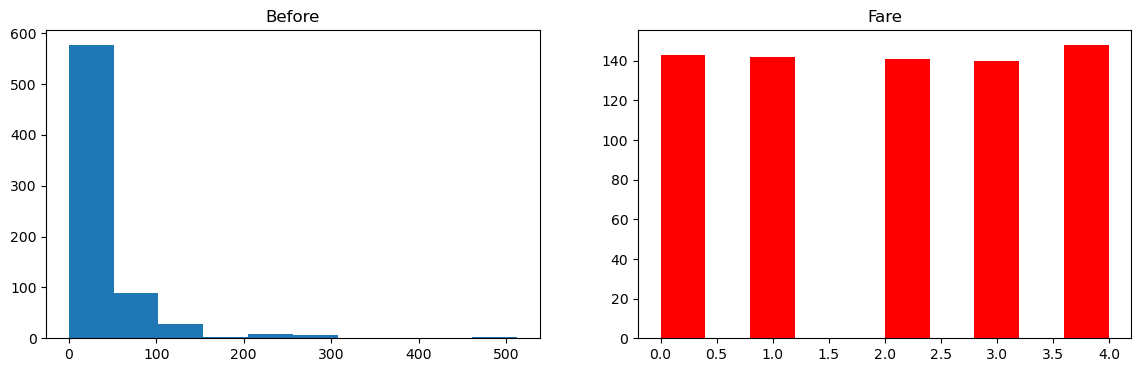

In [43]:
discretize(5,'quantile')

C:\Users\THINKPAD\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\THINKPAD\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


0.6260954616588419


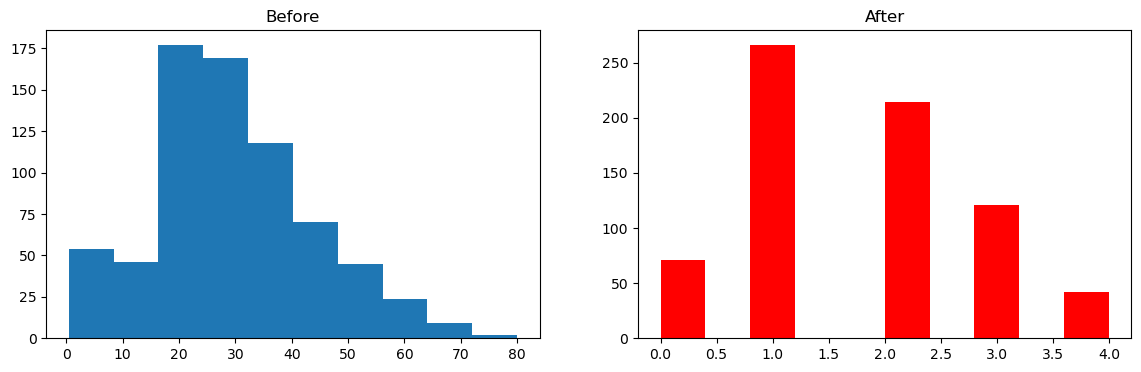

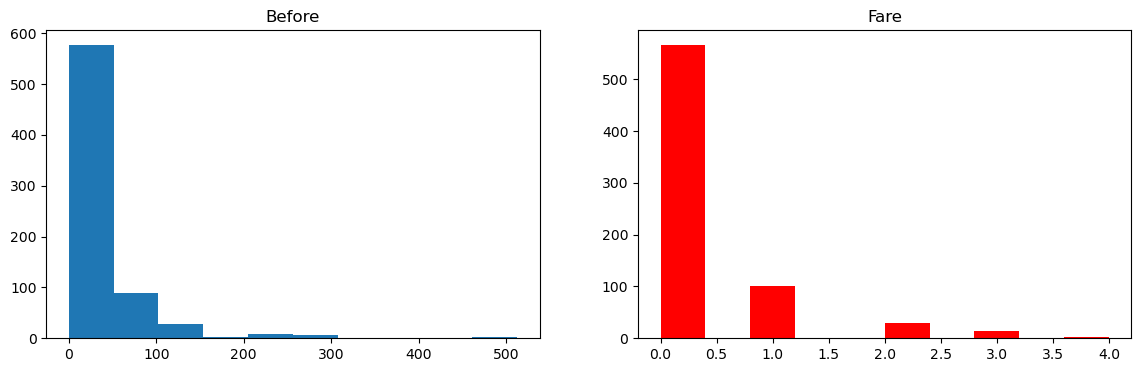

In [44]:
discretize(5,'kmeans')

## quantile performed par better than kmeans and uniform

In [45]:
#although accuracy score is same but performance is better